In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from test_utils import test

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold.

    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num
        seed:   the random seed

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold

    >>> build_k_indices(np.array([1., 2., 3., 4.]), 2, 1)
    array([[3, 2],
           [0, 1]])
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)] # spilt permutation to list of intervals
    return np.array(k_indices)

In [4]:
test(build_k_indices)

✅ Your `build_k_indices` passes some basic tests.


For the following cross_validation( ) function you need to implement, you can help yourselves of the build_poly( ) and ridge_regression( ) functions that you implemented in lab 3. Copy paste the code in the build_polynomial.py and ridge_regression.py files, they should pass the two following tests.

In [5]:
from costs import compute_mse
from ridge_regression import ridge_regression
from build_polynomial import build_poly


test(build_poly)
test(ridge_regression)

✅ Your `build_poly` passes some basic tests.
✅ Your `ridge_regression` passes some basic tests.


In [12]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression for a fold corresponding to k_indices

    Args:
        y:          shape=(N,)
        x:          shape=(N,)
        k_indices:  2D array returned by build_k_indices()
        k:          scalar, the k-th fold (N.B.: not to confused with k_fold which is the fold nums)
        lambda_:    scalar, cf. ridge_regression()
        degree:     scalar, cf. build_poly()

    Returns:
        train and test root mean square errors rmse = sqrt(2 mse)

    >>> cross_validation(np.array([1.,2.,3.,4.]), np.array([6.,7.,8.,9.]), np.array([[3,2], [0,1]]), 1, 2, 3)
    (0.019866645527597114, 0.33555914361295175)
    """
    # ***************************************************
    # get k'th subgroup in test, others in train
    # ***************************************************
    test_indices = k_indices[k]
    train_folds = [x for i,x in enumerate(k_indices) if i != k]
    train_indices = np.concatenate(train_folds)

    x_tr = x[train_indices]
    y_tr = y[train_indices]

    x_te = x[test_indices]
    y_te = y[test_indices]
    
    # ***************************************************
    # form data with polynomial degree
    # ***************************************************
    x_tr = build_poly(x_tr, degree)
    x_te = build_poly(x_te, degree)

    # ***************************************************
    # ridge regression
    # ***************************************************
    weights = ridge_regression(y_tr, x_tr, lambda_)

    # ***************************************************
    # calculate the loss for train and test data
    # ***************************************************
    loss_tr = np.sqrt(2*compute_mse(y_tr, x_tr, weights))
    loss_te = np.sqrt(2*compute_mse(y_te, x_te, weights))

    return loss_tr, loss_te

In [13]:
# can lead to a numerical error if you use an older version than Python 3.9
test(cross_validation)

✅ Your `cross_validation` passes some basic tests.


For polynomial expansion up to degree 7, the choice of lambda which leads to the best test rmse is 0.00853 with a test rmse of 0.298


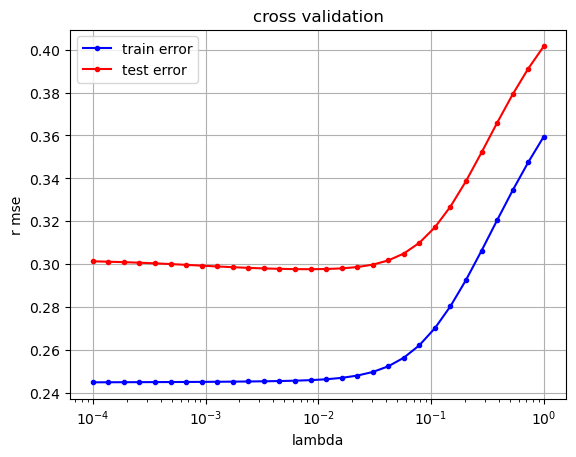

In [14]:
from plots import cross_validation_visualization


def cross_validation_demo(degree, k_fold, lambdas):
    """cross validation over regularisation parameter lambda.

    Args:
        degree: integer, degree of the polynomial expansion
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_lambda : scalar, value of the best lambda
        best_rmse : scalar, the associated root mean squared error for the best lambda
    """

    seed = 12
    degree = degree
    k_fold = k_fold
    lambdas = lambdas
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # ***************************************************
    # cross validation over lambdas
    # ***************************************************
    for lambda_ in lambdas:
        rmse_tr_k = []
        rmse_te_k = []
        # K-fold cross-validation
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_k.append(loss_tr)
            rmse_te_k.append(loss_te)
        rmse_tr_mean = np.mean(rmse_tr_k)
        rmse_te_mean = np.mean(rmse_te_k)
        rmse_tr.append(rmse_tr_mean)
        rmse_te.append(rmse_te_mean)
    
    best_index = np.argmin(rmse_te)
    best_lambda = lambdas[best_index]
    best_rmse = rmse_te[best_index]

    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    print(
        "For polynomial expansion up to degree %.f, the choice of lambda which leads to the best test rmse is %.5f with a test rmse of %.3f"
        % (degree, best_lambda, best_rmse)
    )
    return best_lambda, best_rmse


best_lambda, best_rmse = cross_validation_demo(7, 4, np.logspace(-4, 0, 30))

Your output should look like this for seed = 12, degree = 7 and k_fold = 4:

![alt text](cross_validation2.png)

You can play around with the number of folds and the degree of your polynomial expansion.

For polynomial expansion up to degree 10, the choice of lambda which leads to the best test rmse is 0.00002 with a test rmse of 0.312


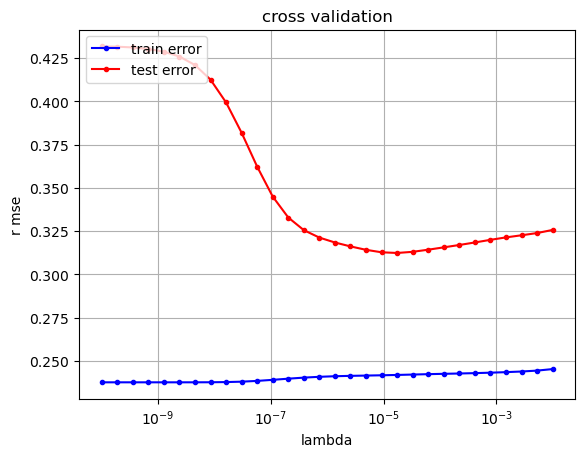

In [15]:
best_lambda, best_rmse = cross_validation_demo(10, 4, np.logspace(-10, -2, 30))

In the previous task we did a grid search over several values of $\lambda$ for a fixed degree. We can also perform a grid search amongst $\lambda$ and degrees simultaneously:

In [16]:
def best_degree_selection(degrees, k_fold, lambdas, seed=1):
    """cross validation over regularisation parameter lambda and degree.

    Args:
        degrees: shape = (d,), where d is the number of degrees to test
        k_fold: integer, the number of folds
        lambdas: shape = (p, ) where p is the number of values of lambda to test
    Returns:
        best_degree : integer, value of the best degree
        best_lambda : scalar, value of the best lambda
        best_rmse : value of the rmse for the couple (best_degree, best_lambda)

    >>> best_degree_selection(np.arange(2,11), 4, np.logspace(-4, 0, 30))
    (7, 0.004520353656360241, 0.28957280566456634)
    """

    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)

    # ***************************************************
    # cross validation over degrees and lambdas
    # ***************************************************
    
    # rmse_tr = [] not useful
    rmse_te = []
    # build cartesian product of degrees x lambdas
    degree_lambda_product = [(x, y) for x in degrees for y in lambdas]

    for degree, lambda_ in degree_lambda_product:
        rmse_tr_k = []
        rmse_te_k = []
        # K-fold cross-validation
        for k in range(k_fold):
            loss_tr, loss_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_k.append(loss_tr)
            rmse_te_k.append(loss_te)
        rmse_te_mean = np.mean(rmse_te_k)
        rmse_te.append(rmse_te_mean)
    
    best_index = np.argmin(rmse_te)
    best_degree, best_lambda = degree_lambda_product[best_index]
    best_rmse = rmse_te[best_index]

    return best_degree, best_lambda, best_rmse

In [17]:
# can lead to a numerical error if you use an older version than Python 3.9
test(best_degree_selection)

best_degree, best_lambda, best_rmse = best_degree_selection(
    np.arange(2, 11), 4, np.logspace(-4, 0, 30)
)
print(
    "The best rmse of %.3f is obtained for a degree of %.f and a lambda of %.5f."
    % (best_rmse, best_degree, best_lambda)
)

✅ Your `best_degree_selection` passes some basic tests.
The best rmse of 0.290 is obtained for a degree of 7 and a lambda of 0.00452.


## Bias-Variance Decomposition

In [18]:
# true function we want to learn
def f_star(x):
    return x**3 - x**2 + 0.5


# plotting function for f_star
def plot_fstar(ax):
    xvals = np.arange(-1, 1, 0.01)
    ax.plot(xvals, f_star(xvals), linestyle="--", color="k", label="f_star")
    ax.set_ylim(-2, 2)

In [19]:
# helper plot function
def plot_poly(x, y, weights, degree, ax, alpha=0.3):
    xvals = np.arange(-1, 1, 0.01)
    tx = build_poly(xvals, degree)
    f = tx.dot(weights)
    ax.plot(xvals, f, color="orange", alpha=alpha)
    ax.scatter(x, y, color="b", alpha=alpha, s=10)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Polynomial degree " + str(degree))
    ax.set_ylim(-1, 2)


# helper plot function
def plot_f(weights, degree, ax, label=None):
    xvals = np.arange(-1, 1, 0.01)
    tx = build_poly(xvals, degree)
    f = tx.dot(weights)
    ax.plot(xvals, f, color="black", alpha=1, label=label)
    ax.set_ylim(-1, 2)

Implement the following function: for 15 random datapoints, it finds the optimal fit (using the least square formula, with no regularisation λ) for a polynomial expansion of degree 1, 3 and 6.

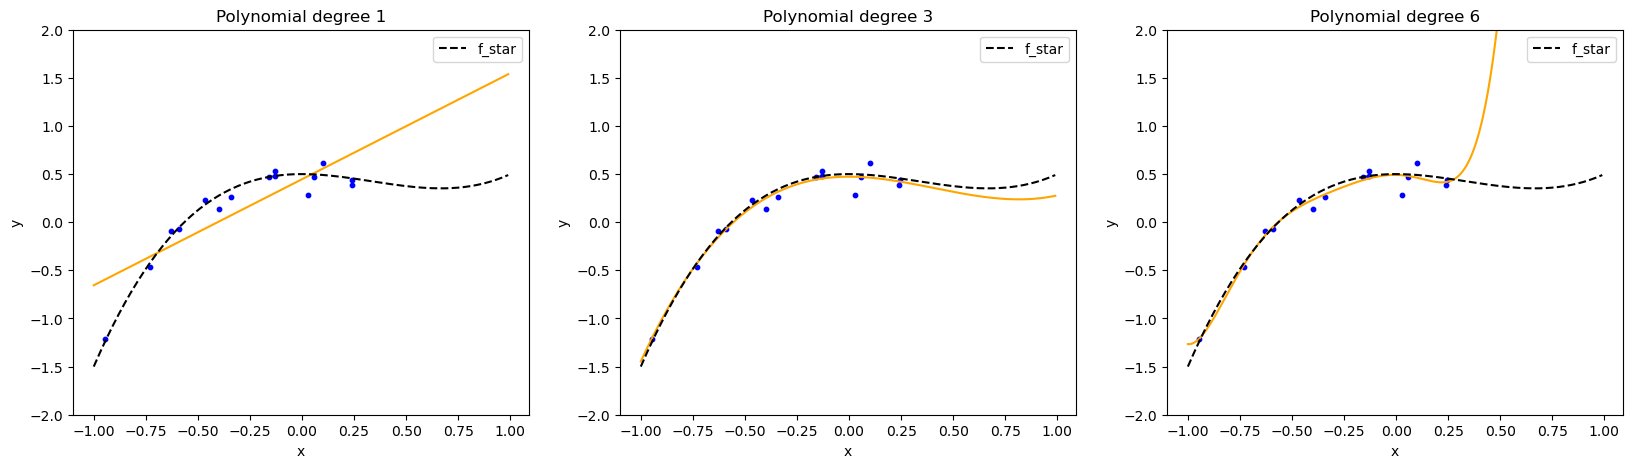

In [21]:
from least_squares import least_squares


def bias_variance_one_seed(sigma, degrees, seed):
    """One run of the optimal fit for 15 random points and different polynomial expansion degrees.

    Args:
        sigma: scalar, noise variance
        degrees: shape = (3,), 3 different degrees to consider
        seed: integer, random see
    Returns:
    """

    # we will generate 15 random datapoints from the [-1, 1] uniform distribuion
    num_data = 15
    np.random.seed(seed)  # set random seed for reproducibility
    xs = np.random.uniform(-1, 1, num_data)
    # the outputs will be f_star(x) + some random gaussian noise of variance sigma**2
    ys = f_star(xs) + sigma * np.random.randn(num_data) # observation = true_val + noise

    fig, axs = plt.subplots(1, len(degrees), figsize=(20, 5))
    for index_degree, degree in enumerate(degrees):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ***************************************************
        
        x = build_poly(xs, degree)
        w, mse = least_squares(ys, x)
        plot_poly(xs, ys, w, degree, axs[index_degree], alpha=1)

        plot_fstar(axs[index_degree])
        axs[index_degree].legend()
    plt.show()


bias_variance_one_seed(0.1, [1, 3, 6], seed=2)

Your output should ressemble (for seed = 2) to this: 
![alt text](bias_variance_one_run.png)

Now to illustrate the bias variance tradeoff we will repeat many times the previous experiment but using a different random seed each time. We also plot (in plain black) the mean of all the orange functions obtained.

[0.18626926 0.59712681]
[ 0.49944767  0.01196655 -1.01128096  0.97140237]
[ 0.50316325  0.0288322  -1.03132559  0.81370526  0.19918955  0.11204401
 -0.04855075]


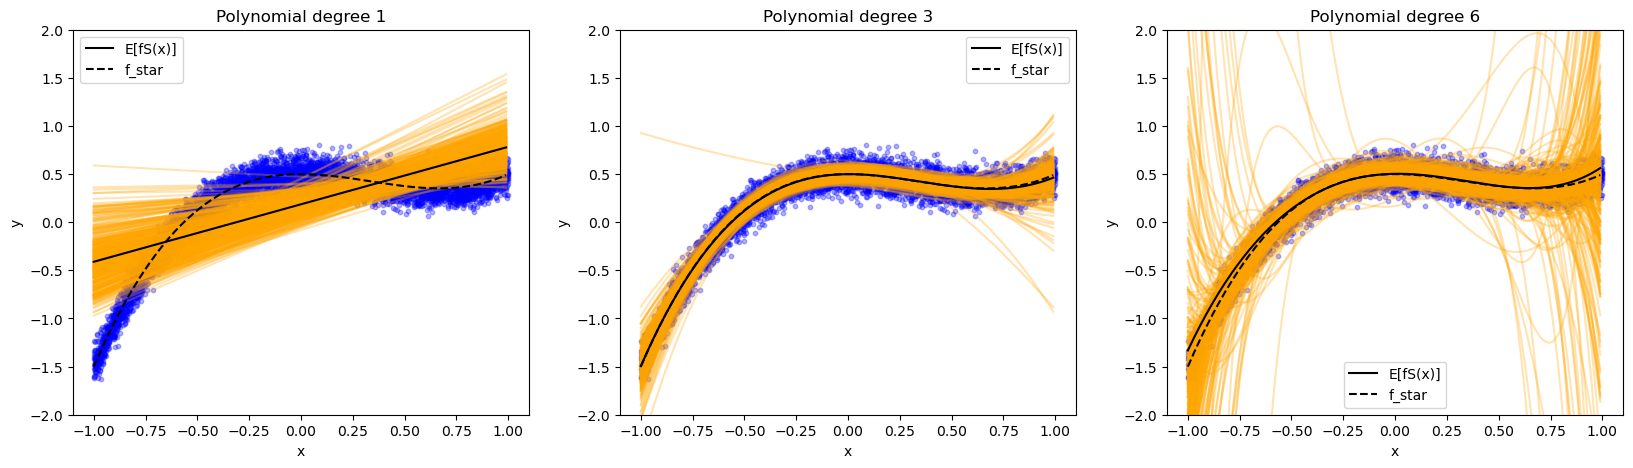

In [43]:
def bias_variance_demo(sigma, degrees):
    """Illustration of the bias-variance tradeoff.

    Args:
        sigma: scalar, noise variance
        degrees: shape = (3,), 3 different degrees to consider
    Returns:
    """
    # define parameters
    seeds = range(400)  # number of runs
    num_data = 15

    fig, axs = plt.subplots(1, len(degrees), figsize=(20, 5))
    for index_degree, degree in enumerate(degrees):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # ***************************************************
        weights = []
        for seed in seeds:
            np.random.seed(seed)
            xs = np.random.uniform(-1, 1, num_data)
            # the outputs will be f_star(x) + some random gaussian noise of variance sigma**2
            ys = f_star(xs) + sigma * np.random.randn(num_data) # observation = true_val + noise

            x = build_poly(xs, degree)
            w, _ = least_squares(ys, x)
            weights.append(w)
            plot_poly(xs, ys, w, degree, axs[index_degree])

        # compute and plot bias (mean)
        w_mean = np.mean(weights, axis=0) # average element wise of np.array in a list of np.array, use axis=0  
        print(w_mean)
        plot_f(w_mean, degree, axs[index_degree], label="E[fS(x)]")

        plot_fstar(axs[index_degree])
        axs[index_degree].legend()
    plt.show()


bias_variance_demo(0.1, [1, 3, 6])

Your output should ressemble to this: 
![alt text](bias_variance.png)